INSTALL & IMPORT NECESSARY LIBRARIES

In [ ]:
!apt-get install -y tesseract-ocr
!pip install tensorflow
!pip install pytesseract pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (10.1 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [ ]:
# Import necessary packages for Image -> Text Extraction
import cv2
import pytesseract
from PIL import Image

# Import necessary packages
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from io import BytesIO
from tokenize import tokenize, COMMENT, NL

PREPROCESSING

In [ ]:
# Load dataset (Upload it to Colab or provide a direct link)
df = pd.read_csv('balanced_snippets.csv')

# Display the first few rows
df.head()

,python_solutions,label
0,"class Solution:\n def twoSum(self, nums: Li...",1
1,class Solution:\n def lengthOfLongestSubstr...,0
2,class Solution:\n def findMedianSortedArray...,1
3,class Solution:\n def longestPalindrome(sel...,0
4,"class Solution:\n def convert(self, s: str,...",0


In [ ]:
df.tail()

,python_solutions,label
3276,"PrInT( ""elderberry"" )\n PrInT( ""cherry"" ...",0
3277,"PrInT( ""date"" )\n PrInT( ""apple"" )\n P...",0
3278,"PrInT( ""cherry"" )\n PrInT( ""banana"" )\n...",0
3279,"PrInT( ""banana"" )",0
3280,"PrInT( ""cherry"" )\n PrInT( ""apple"" )\n ...",0


In [ ]:
# Keep only the relevant columns: 'code_snippet' and 'readability_score'
#df = df[['python_solutions', 'readability']]
# [Since the dataset is already modified, skip this step]

# Convert readability scores to binary labels (1 = Readable, 0 = Unreadable)
#df['label'] = (df['readability'] > 3.9).astype(int)
# [Since the dataset is already modified, skip this step]

# Drop the original readability score column (optional)
#df = df[['python_solutions', 'label']]
# [Since the dataset is already modified, skip this step]

# Extract code snippets and labels
code_snippets = df['python_solutions'].astype(str).tolist()  # Ensure all are strings
labels = df['label'].values  # Binary labels
df.rename(columns={'python_solutions': 'python_codes'}, inplace=True)

In [ ]:
df.head(10)

,python_codes,label
0,"class Solution:\n def twoSum(self, nums: Li...",1
1,class Solution:\n def lengthOfLongestSubstr...,0
2,class Solution:\n def findMedianSortedArray...,1
3,class Solution:\n def longestPalindrome(sel...,0
4,"class Solution:\n def convert(self, s: str,...",0
5,"class Solution:\n def reverse(self, x: int)...",1
6,"class Solution:\n def myAtoi(self, s: str) ...",1
7,"class Solution:\n def isPalindrome(self, x:...",1
8,class Solution:\n @lru_cache\n def isMat...,0
9,"class Solution:\n def maxArea(self, height:...",1


label
0    1652
1    1629
Name: count, dtype: int64


<Axes: title={'center': 'Class Distribution'}, xlabel='label'>

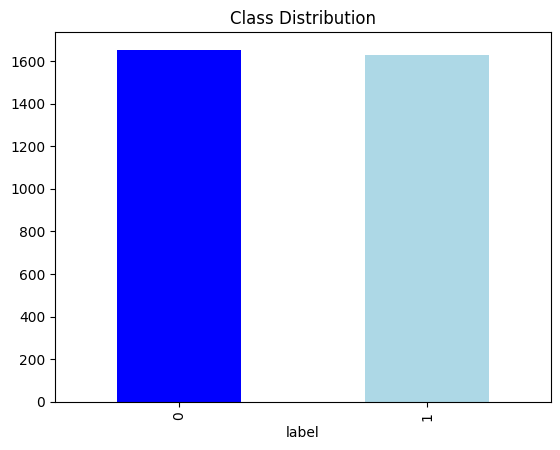

In [ ]:
# Count occurrences of each label
print(df['label'].value_counts())

# Optional: Visualize with a bar plot
df['label'].value_counts().plot(kind='bar', title="Class Distribution", color=['blue', 'lightblue'])

In [ ]:
def clean_code(code):
    if not isinstance(code, str) or len(code.strip()) == 0:
        return "EMPTY_CODE"

    # Remove the following -- "class Solution:", "single & multiline Comments", "Unnecessary punctuation spaces"
    code = re.sub(r'^\s*class Solution:\s*', '', code)
    code = re.sub(r'#.*', '', code) # Remove single line comments
    code = re.sub(r'""".*?"""|\'\'\'.*?\'\'\'', '', code, flags=re.DOTALL)  # Remove multi-line comments
    code = re.sub(r'\s*([,:\])}])', r'\1', code)  # Remove spaces before `, : ] } )`
    code = re.sub(r'([{[(])\s*', r'\1', code)  # Remove spaces after `{ [ (`

    # Normalize indentation (replace tabs with spaces)
    code = code.replace('\t', '    ')

    # Fix missing colons for functions, loops, and conditionals
    code = re.sub(r'(\b(if|for|while|def|class)\b[^\n]*)(?<!:)\n', r'\1:\n', code)

    # Ensure function and class bodies have at least `pass`
    code = re.sub(r'(\b(def|class)\b[^\n]*:)(\n\s*\n)', r'\1\n    pass\n', code)

    return code.strip()

# Apply the function to the dataset
df['clean_code'] = df['python_codes'].apply(clean_code)

# Check results
print(df[['python_codes', 'clean_code']].head())  # Show first 10 rows

                                        python_codes  \
0  class Solution:\n    def twoSum(self, nums: Li...   
1  class Solution:\n    def lengthOfLongestSubstr...   
2  class Solution:\n    def findMedianSortedArray...   
3  class Solution:\n    def longestPalindrome(sel...   
4  class Solution:\n    def convert(self, s: str,...   

                                          clean_code  
0  def twoSum(self, nums: List[int], target: int)...  
1  def lengthOfLongestSubstring(self, s: str) -> ...  
2  def findMedianSortedArrays(self, nums1: List[i...  
3  def longestPalindrome(self, s: str) -> str:\n ...  
4  def convert(self, s: str, numRows: int) -> str...  


In [ ]:
df.head(5)

,python_codes,label,clean_code
0,"class Solution:\n def twoSum(self, nums: Li...",1,"def twoSum(self, nums: List[int], target: int)..."
1,class Solution:\n def lengthOfLongestSubstr...,0,"def lengthOfLongestSubstring(self, s: str) -> ..."
2,class Solution:\n def findMedianSortedArray...,1,"def findMedianSortedArrays(self, nums1: List[i..."
3,class Solution:\n def longestPalindrome(sel...,0,"def longestPalindrome(self, s: str) -> str:\n ..."
4,"class Solution:\n def convert(self, s: str,...",0,"def convert(self, s: str, numRows: int) -> str..."


In [ ]:
# drop 'python_codes'
#df = df.drop(columns=['python_codes'])
# [Since the dataset is modified, skip this step]

# switch ordered columns
df = df[['clean_code', 'label']]

# display 5 rows
df.head(5)

,clean_code,label
0,"def twoSum(self, nums: List[int], target: int)...",1
1,"def lengthOfLongestSubstring(self, s: str) -> ...",0
2,"def findMedianSortedArrays(self, nums1: List[i...",1
3,"def longestPalindrome(self, s: str) -> str:\n ...",0
4,"def convert(self, s: str, numRows: int) -> str...",0


In [ ]:
# display the end of 5 rows
df.tail(5)

,clean_code,label
3276,"PrInT(""elderberry"")\n PrInT(""cherry"")\n PrIn...",0
3277,"PrInT(""date"")\n PrInT(""apple"")\n PrInT(""fig""...",0
3278,"PrInT(""cherry"")\n PrInT(""banana"")\n PrInT(""c...",0
3279,"PrInT(""banana"")",0
3280,"PrInT(""cherry"")\n PrInT(""apple"")\n PrInT(""ba...",0


In [ ]:
# Tokenize code snippets
max_vocab_size = 5000  # Maximum vocabulary size
max_length = 500  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_vocab_size, char_level=True, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_code'])
sequences = tokenizer.texts_to_sequences(df['clean_code'])

# Pad sequences to ensure equal length
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].values, test_size=0.2, random_state=42)

In [ ]:
print("Training Set for Class Distribution:\n", pd.Series(y_train).value_counts())
print("Test Set for Class Distribution:\n", pd.Series(y_test).value_counts())

Training Set for Class Distribution:
 0    1317
1    1307
Name: count, dtype: int64
Test Set for Class Distribution:
 0    335
1    322
Name: count, dtype: int64


CNN

In [ ]:
def create_convnet(name, filters):
    inputs = Input(shape=(max_length,), name=f'{name}_input')
    x = Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length)(inputs)
    x = Conv1D(filters=filters, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=filters*2, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    return inputs, x

# Create three CNN models
cr_input, cr_output = create_convnet("Character", 32)
tr_input, tr_output = create_convnet("Token", 32)
nr_input, nr_output = create_convnet("AST", 32)

# Step 5: Combine CNNs into an Ensemble Model (DeepCRM)
merged = Concatenate()([cr_output, tr_output, nr_output])
dense_layer = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
dropout_layer = Dropout(0.6)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)  # Binary classification

# Define the final model
model = Model(inputs=[cr_input, tr_input, nr_input], outputs=output_layer)

#Adam Optimizer
lr_schedule = ExponentialDecay(initial_learning_rate=0.0003, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Character_input           │ (None, 500)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Token_input (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ AST_input (InputLayer)    │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 128)       │        640,000 │ Character_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 500, 128)       │        640,000 │ Token_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 500, 128)       │        640,000 │ AST_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 498, 32)        │         12,320 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 498, 32)        │         12,320 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 498, 32)        │         12,320 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 249, 32)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 249, 32)        │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 249, 32)        │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 247, 64)        │          6,208 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 247, 64)        │          6,208 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 247, 64)        │          6,208 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 123, 64)        │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 123, 64)        │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)       

 Total params: 4,998,689 (19.07 MB)

 Trainable params: 4,998,689 (19.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Check dataset balance
print(df['label'].value_counts())  # Check readable vs. unreadable

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)

history = model.fit(
    [X_train, X_train, X_train],  # Input three times since same data is used for all CNNs
    y_train,
    epochs=25, # Increased from 15
    batch_size=32,  #Prevent overfitting and better generalization
    validation_data=([X_test, X_test, X_test], y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

label
0    1652
1    1629
Name: count, dtype: int64
Class Weights: {0: 0.9962034927866363, 1: 1.0038255547054322}
Epoch 1/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.6704 - loss: 1.8508 - val_accuracy: 0.8706 - val_loss: 0.4841
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 31s 288ms/step - accuracy: 0.8800 - loss: 0.4203 - val_accuracy: 0.8752 - val_loss: 0.3965
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.8868 - loss: 0.3606 - val_accuracy: 0.8737 - val_loss: 0.3505
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 275ms/step - accuracy: 0.9008 - loss: 0.3180 - val_accuracy: 0.8721 - val_loss: 0.3668
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - accuracy: 0.8881 - loss: 0.3238 - val_accuracy: 0.8950 - val_loss: 0.3291
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.9113 - loss: 0.2723 - val_accuracy: 0.8813 - val_loss: 0.3311
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 275ms/step - accuracy: 0.9240 - loss: 0.2746 - val_accuracy: 0.8858 - 

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate([X_test, X_test, X_test], y_test)

# Print final accuracy and loss
print("Final Test Accuracy Score: {:.4f}".format(test_acc))
print("Final Test Loss Score: {:.4f}".format(test_loss))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8875 - loss: 0.3268
Final Test Accuracy Score: 0.9041
Final Test Loss Score: 0.3086


In [ ]:
actual_readable = (df['label'] == 1).sum()
actual_unreadable = (df['label'] == 0).sum()
print("Actual Readable Score: " + str(actual_readable) + " out of " + str(len(df)) + " (" + str(round((actual_readable / len(df)) * 100, 2)) + "%)")
print(f"Actual Unreadable Score: " + str(actual_unreadable) + " out of " + str(len(df)) + " (" + str(round((actual_readable / len(df)) * 100, 2)) + "%)")

Actual Readable Score: 1629 out of 3281 (49.65%)
Actual Unreadable Score: 1652 out of 3281 (49.65%)


In [ ]:
# Generate predictions for the test set
y_pred = model.predict([X_test, X_test, X_test])

# Convert predictions to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [ ]:
# Get predictions for ALL data, not just X_test
predictions = model.predict([X, X, X])  # Use full dataset `X`

# Convert predictions to binary (readable/unreadable)
pred_labels = (predictions > 0.5).astype(int).flatten()

# Count predicted values
readable_count = (pred_labels == 1).sum()
unreadable_count = (pred_labels == 0).sum()

# Print results
print("Predicted Readable Code: {} out of {}".format(readable_count, len(X)))
print("Predicted Unreadable Code: {} out of {}".format(unreadable_count, len(X)))

103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step
Predicted Readable Code: 1614 out of 3281
Predicted Unreadable Code: 1667 out of 3281


In [ ]:
def predict_readability(code_snippet):
    """
    This function simulates code readability prediction.
    - Takes a raw code snippet [python code] as input.
    - Preprocesses it [e.g. cleaning, tokenizing, etc.] for model input.
    - Once done, the model displays a user-friendly message alongside the code status [whether readable or unreadable].
    """
    # Ensure tokenizer is loaded
    global tokenizer
    if tokenizer is None:
        print("Error: Tokenizer is not initialized.")
        return "Tokenizer is missing. Kindly train the model first."

    # Step 1: Clean the input code snippet (ensure clean_code() is defined)
    cleaned_code = clean_code(code_snippet)

    # Step 2: Tokenize and pad sequence
    sequence = tokenizer.texts_to_sequences([cleaned_code])
    padded_sequence = pad_sequences(sequence, maxlen=500, padding='post')

    # Step 3: Predict readability (Make sure the model expects 3 inputs)
    prediction = model.predict([padded_sequence, padded_sequence, padded_sequence])
    score = prediction[0][0]  # Extract predicted score

    # Step 4: Determine readability
    if score > 0.4:
        message = "✅ The given python code is **READABLE**."
    else:
        message = "❌ The given python code is **UNREADABLE**."

    # Step 5: Display result with a confidence score
    return "{}\n🔹 Confidence Score is: **{:.4f}**".format(message, score)

In [ ]:
# SAMPLE READABLE CODE
sample_readable = df[df['label'] == 1].sample(1)['clean_code'].values[0]
print("Sample Readable Code:\n", sample_readable)
print(predict_readability(sample_readable))

Sample Readable Code:
 print("The fruit is: elderberry")
print("The fruit is: fig")
print("The fruit is: grape")
print("The fruit is: grape")
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
✅ The given python code is **READABLE**.
🔹 Confidence Score is: **0.9980**


In [ ]:
# SAMPLE UNREADABLE CODE
unreadable_code = """
prifansts(""Hello World''s")
"""

print(predict_readability(unreadable_code))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
❌ The given python code is **UNREADABLE**.
🔹 Confidence Score is: **0.0139**


In [ ]:
def extract_text_from_image(image_path):
    """
    Extracts text (code snippets) from an image using OCR.
    """
    # Load image
    img = cv2.imread(image_path)

    # Convert to grayscale for better OCR performance
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding (optional, helps with text clarity)
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Use Tesseract to extract text
    extracted_text = pytesseract.image_to_string(gray, config='--psm 6')  # PSM 6: Assume a uniform block of text

    return extracted_text.strip()  # Remove extra spaces & newlines

In [ ]:
def classify_image_code(image_path):
    """
    Extracts code from an image and predicts its readability using the trained CNN model.
    """
    # Extract text (code) from the image
    extracted_code = extract_text_from_image(image_path)

    # Clean the extracted code (same cleaning as before)
    cleaned_code = clean_code(extracted_code)

    # Convert text into tokenized sequence
    sequence = tokenizer.texts_to_sequences([clean_code])

    # Pad the sequence to match the CNN input length
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Predict readability
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction, axis=1)[0]  # 0 = Unreadable, 1 = Readable

    # Print results
    print("\nExtracted Code:\n{}".format(extracted_code))
    print("Predicted Readability: {}".format("Readable" if predicted_class == 1 else "Unreadable"))

    return extracted_code, predicted_class

CLASSIFICATION REPORT


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       335
           1       0.90      0.90      0.90       322

    accuracy                           0.90       657
   macro avg       0.90      0.90      0.90       657
weighted avg       0.90      0.90      0.90       657


Confusion Matrix:
[[304  31]
 [ 32 290]]


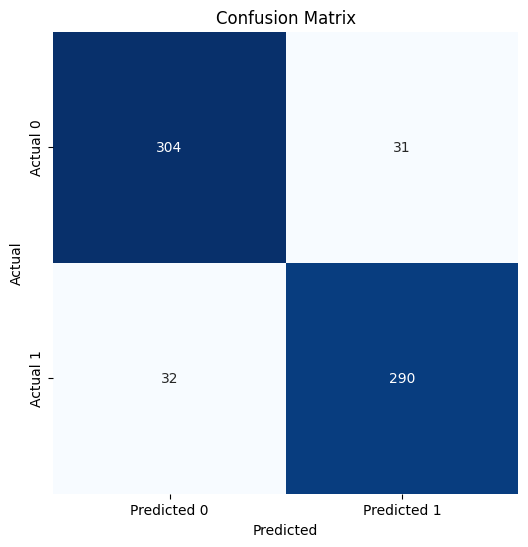

In [ ]:
# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix (optional)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()